In [1]:
# Importing dependencies
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# Let's prepare a tensorflow model for our autoencoder
# We will have a 3 feature input encoded in 2 neurons and then decode back to the original 3 features
# So it's possible to see the results in a plot
n_input = 3
n_encoding = 2

In [3]:
# Mocking normal distributed values for the training and test data
train_values = np.random.normal(size=(700, n_input))
test_values = np.random.normal(size=(300, n_input))

In [4]:
def createAutoencoder(n_inputs, n_encoding):
    # Input Layer
    x = tf.placeholder(tf.float32, [None, n_inputs], name="input")

    # We will group the encoding layer operations in a scope
    with tf.name_scope('encoding_layer') as scope: 
        hidden_layer_weights = tf.Variable(tf.random_normal([n_inputs, n_encoding]), name="encoding_weigths")
        hidden_layer_bias = tf.Variable(tf.random_normal([n_encoding]), name="encoding_bias")
        encoding = tf.add(tf.matmul(x, hidden_layer_weights), hidden_layer_bias, name='encoding_layer')

    # We will also group the output layer in a scope
    with tf.name_scope('decoding_layer') as scope:
        output_layer_weights = tf.Variable(tf.random_normal([n_encoding, n_inputs]), name="decoding_weigths")
        output_layer_bias = tf.Variable(tf.random_normal([n_inputs]), name="output_bias")
        decoding = tf.add(tf.matmul(encoding, output_layer_weights), output_layer_bias, name='decoding_layer')
    
    return (x, encoding, decoding)

In [5]:
# The loss is the mean euclidean distance between the inputs and outputs
x, encoding, decoding = createAutoencoder(n_input, n_encoding)
euclidean_dist = tf.sqrt(
        tf.reduce_sum(
        tf.square(
            tf.subtract(decoding, x)
        ), axis=1), name="pair_wise_euclidean_distance")

loss = tf.reduce_mean(euclidean_dist,name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=0.25).minimize(loss)
# I decided to define the accuracy as the ratio of predictions thate inside
# a unit sphere around correspondent input
accuracy = tf.reduce_mean(tf.cast(tf.less(euclidean_dist, 1), tf.float32))

In [6]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for e in range(2500):
        # Run the training step
        l, _ = sess.run([loss, optimizer], feed_dict={x: train_values})
        if e % 500==0:
            test_loss,test_acc = sess.run([loss, accuracy], feed_dict={x:test_values})
            #print("Train Loss: %.4f | Test Loss %.4f" % (l, test_loss))
            #print("Test Acc: %.4f" % test_acc)
    # Encode and decode all the test values so we can plot them
    d = sess.run(decoding, feed_dict={x: test_values})
    sess.close()

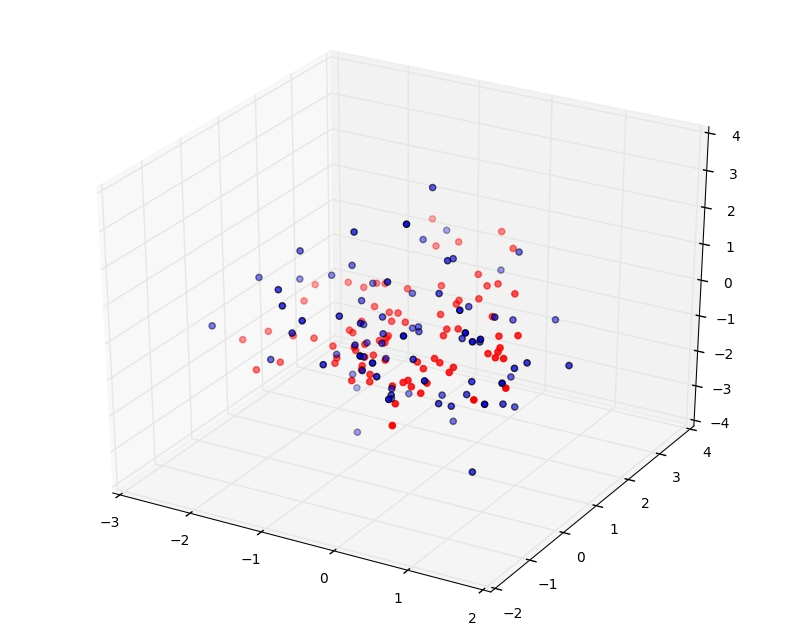

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
#We will plot only the 50 first values
tv = test_values[:80]
d = d[:80]

test_points = [[v[0] for v in tv],[v[1] for v in tv],[v[2] for v in tv]]
decoded = [[v[0] for v in d], [v[1] for v in d],[v[2] for v in d]]

plt.scatter(test_points[0], test_points[1], zs=test_points[2], depthshade=True)
plt.scatter(decoded[0],decoded[1], zs=decoded[2] , color ='red', depthshade=True)

We can see the decoded data translate to a plane, which makes sense, since that's what we can represent with 2 hidden, neurons, now that we have a working POC for our auto encoder, let's see how it compares to standard PCA

In [8]:
# We will need sklearn's PCA module
import sklearn.decomposition as skldc
import sklearn.preprocessing as sklpp

In [9]:
poke_data = pd.read_csv('../datasets/pokemon-stats.csv')
poke_data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [10]:
# We will see how well our AutoEncoder can reduce the features of the data
# to do this, we will first apply a PCA, reducing the features targeting the Type 1
# column, the we will train our AutoEncoder, the final dimension should be 3 (so we can plot it)
# first, let's drop the columns we won't need and also, categorize the type 1 and legendary columns
treated_data = poke_data.drop(['#', 'Name', 'Type 2'], axis=1)
treated_data["Type 1"] = treated_data["Type 1"].rank(method="dense")
treated_data["Legendary"] = treated_data["Legendary"].apply(lambda x: 1 if x=='True' else 0)
treated_data.head()

,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,10.0,318,45,49,49,65,65,45,1,0
1,10.0,405,60,62,63,80,80,60,1,0
2,10.0,525,80,82,83,100,100,80,1,0
3,10.0,625,80,100,123,122,120,80,1,0
4,7.0,309,39,52,43,60,50,65,1,0


In [11]:
pca_targets = treated_data["Type 1"]
pca_data = treated_data.drop("Type 1", axis=1)
pca_data = sklpp.StandardScaler().fit_transform(pca_data)

In [12]:
# We want to reduce it to 3 components
pca = skldc.PCA(n_components=3).fit(pca_data)
pca.components_

array([[ 0.51853234,  0.32945198,  0.37801677,  0.31314747,  0.38980094,
         0.37971841,  0.29027307,  0.03518934, -0.        ],
       [-0.01420186,  0.10439537,  0.00128082,  0.57105747, -0.28352599,
         0.20315863, -0.63985901,  0.36292102,  0.        ],
       [ 0.01636274, -0.06341564, -0.04954756,  0.28499689, -0.09862095,
         0.17005868, -0.17901433, -0.91724607,  0.        ]])

In [59]:
x, enc, dec = createAutoencoder(9, 3)
euclidean_dist = tf.sqrt(
        tf.reduce_sum(
        tf.square(
            tf.subtract(dec, x)
        ), axis=1), name="pair_wise_euclidean_distance")

loss = tf.reduce_mean(euclidean_dist,name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for e in range(50000):
        l, _ = sess.run([loss, optimizer], feed_dict={x:pca_data})
        if e % 5000 == 0:
            print(l)
    encodings = sess.run(enc, feed_dict={x:pca_data})
    sess.close()

9.31003
1.26012
1.26049
1.26056
1.26013
1.26067
1.26137
1.26072
1.26029
1.26019


In [60]:
pca_transformed = pca.transform(pca_data)
s = 0 
for i in range(len(pca_transformed)):
    v = sum([(x-y)**2 for x,y in zip(encodings[i], pca_transformed[i])])*(1/2)
    s += v
print(s/len(pca_transformed))

6.5602639341


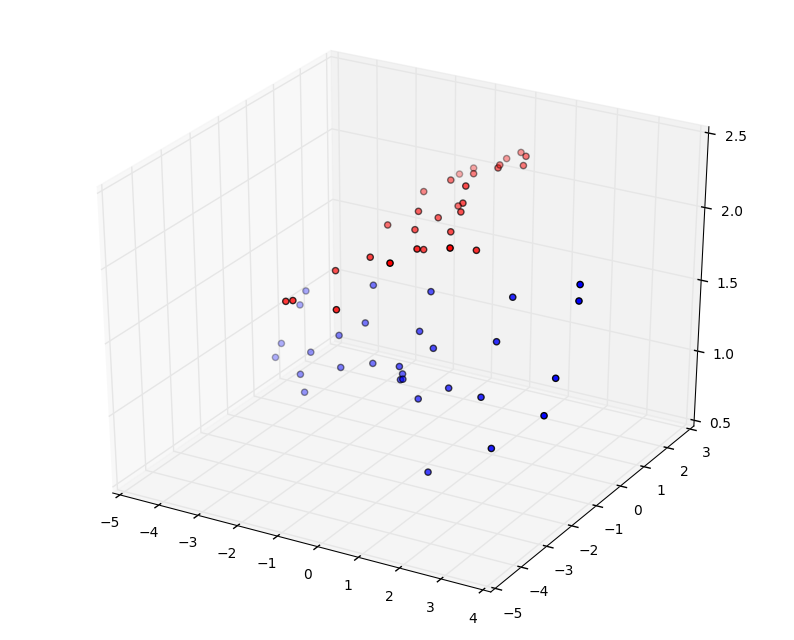

In [58]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
pca_points = pca_transformed[:30]
ae_points = encodings[:30]
plt.scatter([x[0] for x in pca_points],[x[1] for x in pca_points], zs=[x[2] for x in pca_points], depthshade=True)
plt.scatter([x[0] for x in ae_points],[x[1] for x in ae_points], zs=[x[2] for x in ae_points], depthshade=True, c='r')

As we can see, our autoencoder does not perform very well (meaning it doesn't come close to the PCA results), the average euclidean distance beetwen PCA and AutoEncoder points was around 6.5, and by the plot above, we can see the results are very far away